In [2]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import joblib

In [3]:
df = pd.read_csv('data/address_data_combined.csv')


In [4]:
X = df.drop(columns=['Address','FLAG'])
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
import numpy as np

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
  X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

np.isnan(X_train)
joblib.dump(scaler, "models/scaler.pkl")  # Save the scaler

['models/scaler.pkl']

In [5]:
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1000,1500,100),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [6]:
clf = XGBClassifier(
    objective='binary:logistic',
    seed=42
    )


In [7]:
tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=2)

In [8]:
tuned_clf.fit(X_train,y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   1.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   1.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.7s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.2s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.2s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.2s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   1.1s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1200; total time=   1.0s
[CV] END ..learning_rate=0.1, max_depth=2, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(1000, 1500, 100)},
             scoring='f1', verbose=2)

In [9]:
print("Tuned Hyperparameters :", tuned_clf.best_params_)
print("Train F1 Score :",tuned_clf.best_score_)
best_y_pr = tuned_clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1400}
Train F1 Score : 0.9277129516682235
Test F1 Score:  0.9335708831763807


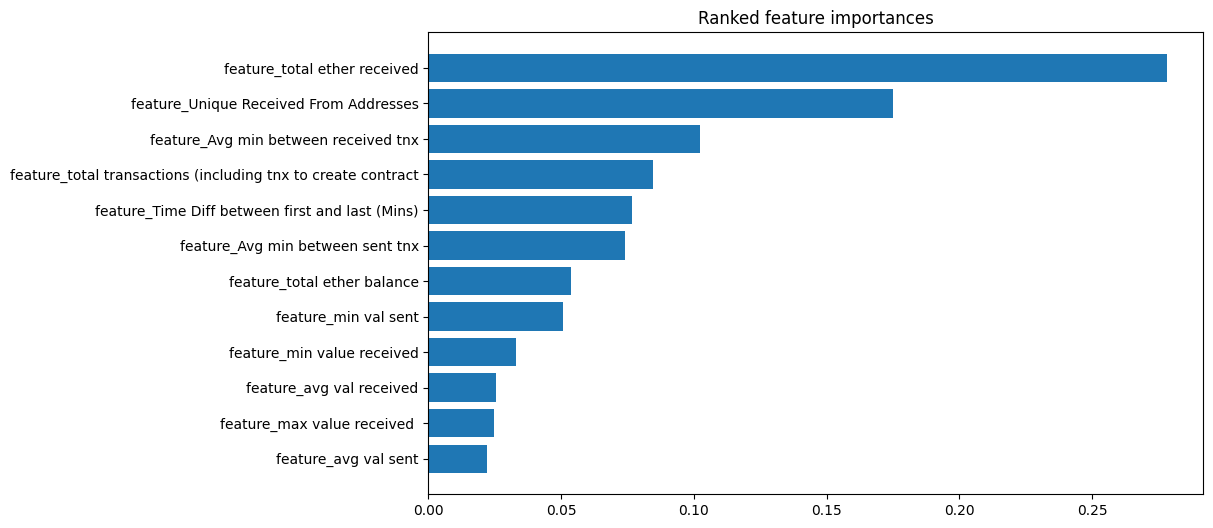

In [10]:
from matplotlib import pyplot as plt
feat_importances = tuned_clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [11]:
tuned_clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
tuned_clf.best_score_

0.9277129516682235

In [13]:
y_pred = tuned_clf.predict(X_test)
xgb_accuracy_score = accuracy_score(y_test, y_pred)
xgb_auc_score = roc_auc_score(y_test, y_pred)
print('XGBoost model accuracy score: {0:0.4f} '
'and roc_auc score: {0:0.4f}'. format(xgb_accuracy_score,xgb_auc_score))

XGBoost model accuracy score: 0.9385 and roc_auc score: 0.9385


In [14]:
# Persis the model 
joblib.dump(tuned_clf, 'models/fraud_model.pkl')

['models/fraud_model.pkl']